In [31]:
import os
import time
from datetime import datetime

import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import random 
from sklearn.model_selection import KFold


# Tensorflow

In [32]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

True

# Case

In [33]:
folders = ['Rough','UTS','Elon']
index = 0
CASE = folders[index]

In [34]:
from prepross import importForK
x,y = importForK(index)

# Get Networks

In [35]:
# Hyperparameters
lossfn = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.losses.MeanAbsoluteError()]
lossfn = lossfn[index]
optimizer = [tf.keras.optimizers.Adam(learning_rate=i,beta_1=0.09,beta_2=0.9) for i in [5e-2,1e-2,5e-3]]
optimizer = optimizer[index]
metrics = ['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]

In [36]:
#Models
files = [f for f in os.listdir(CASE) if f.startswith(CASE) and f.endswith('k.h5')]
files.sort()

# Get Folds

In [37]:
def changeElex(a):
    a = np.array(a)
    temp=a[:,0,:]
    a[:,0,:]=a[:,-1,:]
    a[:,-1,:]=temp
    return np.array(a)

def changeEley(a):
    a = np.array(a)
    temp=a[:,0]
    a[:,0]=a[:,-1]
    a[:,-1]=temp
    return np.array(a)
    
xtrain =[]
xtest = []
ytrain =[]
ytest = []
n_split = 10
for train_index,test_index in KFold(n_split).split(x):
    xtrain.append(x.values[train_index])
    xtest.append(x.values[test_index])
    ytrain.append(y.values[train_index])
    ytest.append(y.values[test_index])
xtrain = changeElex(xtrain)
xtest = changeElex(xtest)
ytrain = changeEley(ytrain)
ytest = changeEley(ytest)


# Model Evaluation

In [38]:
tperformance = {}
performance = {}

for i,f in enumerate(files):
    if i%10==0:
        arch = f[len(CASE)+1:-18]
    else:
        arch = f[len(CASE)+1:-17]
    performance[str(arch)] = {
        'MSE':0,
        'MAE':0,
        'MRE':0
    }
    tperformance[str(arch)] = {
        'MSE':0,
        'MAE':0,
        'MRE':0
    }

In [39]:
models ={}
for i,f in enumerate(files):
    name = f
    if i%10==0:
        arch = f[len(CASE)+1:-18]
        print(i/10+1)
    else:
        arch = f[len(CASE)+1:-17]
    v = f[-15:-13]
    models[str(f)] = tf.keras.models.load_model(os.path.join(CASE+"/"+f),compile=False)
    models[str(f)].compile(
        optimizer = tf.optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam'),
        loss = lossfn,
        metrics = ['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]
    )
    perf = models[str(f)].evaluate(xtest[i%10],ytest[i%10], verbose=0)
    tperformance[str(arch)]['MSE']+=perf[1]
    tperformance[str(arch)]['MAE']+=perf[2]
    tperformance[str(arch)]['MRE']+=perf[3]
    
    perf = models[str(f)].evaluate(x,y, verbose=0)
    performance[str(arch)]['MSE']+=perf[1]
    performance[str(arch)]['MAE']+=perf[2]
    performance[str(arch)]['MRE']+=perf[3]
    


1.0


## Sort by Performence

In [40]:
def value_getter(item):
    return item[1]["MAE"]
sortP = sorted(tperformance.items(),key=value_getter)
sortO =sorted(performance.items(),key=value_getter)
print('Performance on test',sortP[0])
print('Performance on df',sortO[0])

Performance on test ('4tanh1_5linear1_1linear1', {'MSE': 57857.34356689453, 'MAE': 614.2154531478882, 'MRE': 462.1757698059082})
Performance on df ('4tanh1_5linear1_1linear1', {'MSE': 56278.953125, 'MAE': 579.1563491821289, 'MRE': 476.4003143310547})


In [41]:
modelNamesP = [f for f in models.keys() if f.startswith(CASE+"@" + sortP[0][0]) and f.endswith('k.h5')]
modelNamesO = [f for f in models.keys() if f.startswith(CASE+"@" + sortO[0][0]) and f.endswith('k.h5')]

In [42]:
perfO = {}
perfP = {}
for m in modelNamesP:
    model = models[m]
    perfP[m] = model.evaluate(x,y,verbose=0)

for m in modelNamesO:
    model = models[m]
    perfO[m] = model.evaluate(x,y,verbose=0)

In [43]:
def value_getter(item):
    return item[1][0]
sortPP = sorted(perfO.items(),key=value_getter)
sortOO =sorted(perfP.items(),key=value_getter)
print('Performance on test',sortPP[0])
print('Performance on df',sortOO[0])

Performance on test ('Rough@4tanh1_5linear1_1linear1__v4@11-53-45k.h5', [4383.3017578125, 4383.3017578125, 51.3962287902832, 43.2945442199707])
Performance on df ('Rough@4tanh1_5linear1_1linear1__v4@11-53-45k.h5', [4383.3017578125, 4383.3017578125, 51.3962287902832, 43.2945442199707])


In [44]:
Pmodel = models[sortPP[0][0]]
vP = int(sortPP[0][0][-14:-13])
Omodel = models[sortOO[0][0]]
vO = int(sortOO[0][0][-14:-13])

# Regression Plot

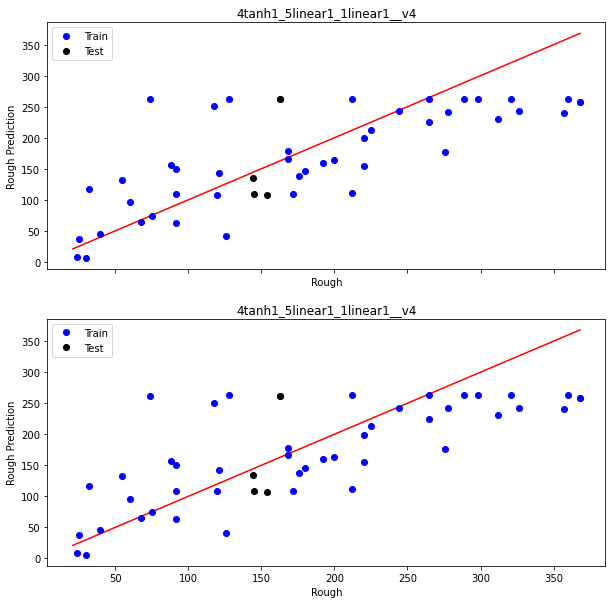

In [45]:
rows, cols = 2,1
fig, gs = plt.subplots(rows, cols,figsize =(10,10),sharex='col',sharey='row')

for i,(mod,ve) in enumerate(([Pmodel,vP],[Omodel,vO])):    
    ypred_tr =  mod.predict(xtrain[ve],verbose=0).squeeze()
    ypred_te = mod.predict(xtest[ve],verbose=0).squeeze()
    ax = fig.add_subplot(gs[i])
    ax.plot(y,y,'r')
    ax.plot(ytrain[ve],ypred_tr,'bo',label="Train")
    ax.plot(ytest[ve],ypred_te,'ko',label = 'Test')
    ax.legend()
    plt.title(mod.name)
    plt.xlabel(CASE)
    plt.ylabel(CASE +' Prediction')
plt.show()